In [1]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join as oj
import sys
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
sys.path.append('..')
import src.transforms
import src.viz as viz
from src.config import DIR_IMAGENET_DATA
import src.attributions

# load data + models

In [2]:
device = 'cuda'

# load models
pre = True
m1 = models.alexnet(pretrained=pre).eval().to(device)
m2 = models.vgg11(pretrained=pre).eval().to(device)
m3 = models.resnet18(pretrained=pre).eval().to(device)
m4 = models.densenet121(pretrained=pre).eval().to(device)
m5 = models.googlenet(pretrained=pre).eval().to(device)
ms = [m1, m2] #, m3, m4, m5]
names = ['alexnet', 'vgg11', 'resnet18', 'densenet121', 'googlenet']

In [3]:
# load data
dset_name = 'val/val' # train or val/val
dset_val = dset.ImageFolder(oj(DIR_IMAGENET_DATA, dset_name), 
                            transforms.Compose([transforms.Resize(256),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                src.transforms.normalize]))

# make preds

100%|██████████| 100/100 [00:05<00:00, 18.02it/s]


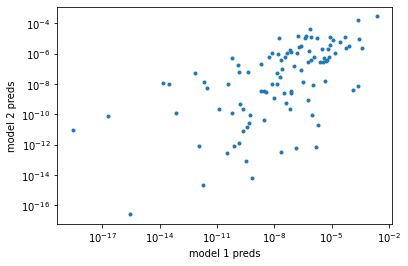

In [13]:
n = 100
preds1 = np.zeros((n, 1000))
preds2 = np.zeros((n, 1000))
labs = np.zeros(n)
for i in tqdm(range(n)):
    idx = np.random.randint(0, 50000)
    x = dset_val[idx][0].unsqueeze(0).to(device)
    labs[i] = dset_val[idx][1]
    preds1[i] = m1(x).softmax(dim=1).detach().cpu().flatten()
    preds2[i] = m2(x).softmax(dim=1).detach().cpu().flatten()
plt.loglog(preds1[:, 0], preds2[:, 0], '.')
plt.xlabel('model 1 preds')
plt.ylabel('model 2 preds')
plt.show()

# look at attributions

In [ ]:
class_num = 0 # class for interpretation

# pick an image
idx = 0 #np.random.randint(0, 50000)
im = dset_val[idx][0].unsqueeze(0).to(device)
lab = dset_val[idx][1]

attrs = {
    k: [] for k in ['CD'] #['Gradient', 'InputXGradient', 'IG', 'SHAP']
}
for m in ms:
    for k in attrs.keys():
        x = deepcopy(im)
        attr = src.attributions.get_attributions(x, m,
                                                 class_num=class_num,
                                                 sweep_dim=7,
                                                 attr_methods=[k], device=device)[k]
        attrs[k].append(attr)

In [ ]:
for k in attrs.keys():
    viz.plot_row(attrs[k], normalize=True, annot_list=names, ylab=k)
    viz.savefig(f'attrs_{k}')